### Student Name: Aidan Keeshan
### Student ID: 18200117

# Lab 4: Comparison of Classifiers

## Task 1 (CS5062)

    Watch the video playlist CS5062-E-tivity4 (ca. 40 min).
    Read the article How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python.
    Use the following files (available in the GitLab repository):
        Lab 4 - Comparison of Classifiers - Main.ipynb - This is the main example notebook to follow these two weeks. It contains code for training and evaluating SVM and Naïve Bayes classifiers.
        Lab4_Functions.ipynb - This notebook contains some functions used in the man example notebook. They have been put in a separate file to keep the main notebook easier to follow.
        seeds_dataset_binary.csv - This is the data set used in the main example notebook.
        data set loans_et4.csv. This is a modified version of the loans data set with 1 for Loan_Status = Yes and 0 for Loan_Status = No. You are asked to work with this data set in Tasks 1-3.
    Replicate the classifier training and evaluation demonstrated in the main example notebook Lab 4 - Comparison of Classifiers - Main.ipynb but with the data set loans_et4.csv and target attribute Loan_Status.   
    Then train another probabilistic classifier with loans_et4.csv add compare it to both SVM and Naïve Bayes. For this third classifier, you can pick any scikit-learn probabilistic classification algorithm apart from SVM and Naive Nayes.   
    Summarise your conclusions (max 150 words in a markdown cell).


This notebook demonstrates how to choose the best out of a few alternative classification models by applying cross-validation and comparing the accuracy of prediction, the F1-scores and the ROC curves of the classification models.

Here we use a _modified version_ of the __seeds data set__ (see https://archive.ics.uci.edu/ml/datasets/seeds), which is one of the public UCI data sets. Each example is a seed described by a few numerical attributes. The target variable for classification (in this example) is the type of the seed, which can be either 1 or 0. Class 1 are the seeds of a particular type that, we can assume, is important to learn to predict correctly, while class 0 are all other seeds.

In this example, we use 5-fold cross-validation. Empirical evidence suggests that 10 folds are probably the best choice for cross-validation, i.e. 10-fold cross-validation. However, since this data set is relatively small, and 1/10 of it is only 21 examples, it is sensible to use larger folds for testing. Thus, we demonstrate the comparison of classifiers with 5-fold cross-validation.

The code in this notebook was originally inspired by the example at https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html.

## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from scipy import interp

### Import evaluation and plotting functions

In [2]:
%run ./Lab4_Functions_18200117.ipynb

### Load and prepare the dataset for training and evaluating a classifier
Feel free to apply any other pre-processing technique at this point.

In [3]:
lab4_df = pd.read_csv("loans_et4.csv")
lab4_df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.797917,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [4]:
# target attribute
target = lab4_df['Loan_Status']

# predictor attributes
predictors = lab4_df.drop('Loan_Status', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### Prepare an array of 100 equally spaced false-positive-rate values between 0 and 1
To be used as an x-axis in ROC curve plots.

In [5]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

## B. Evaluation and Comparison of Classifiers

### Train a Probablistic SVM Classifier

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def eval_clf(clf_str):
    base_str = """accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM, precision_SVM, recall_SVM = evaluate_classifier(folds=5,p=predictors, t=target, classifier=SVM_classifier, mean_fpr=mean_fpr)"""
    return base_str.replace('SVM',clf_str)
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
#accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM, precision_SVM, recall_SVM = evaluate_classifier(folds=5,p=predictors, t=target, classifier=SVM_classifier, mean_fpr=mean_fpr)

exec(eval_clf('SVM'))


# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

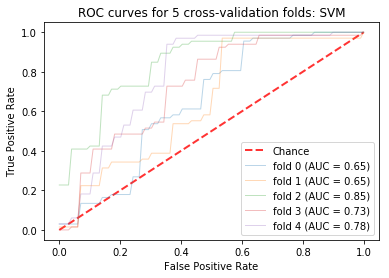

In [7]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

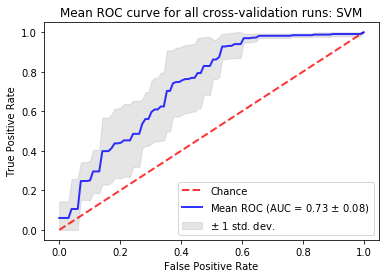

In [8]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

### Train a Naive Bayes Classifier

In [9]:
NB_classifier = GaussianNB()
exec(eval_clf('NB'))

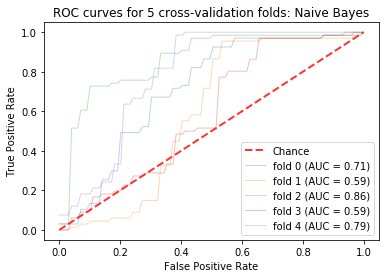

In [10]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

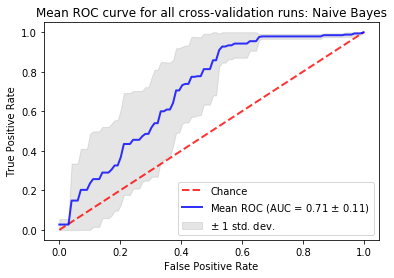

In [11]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

### Train a Random Forest Classifier

In [12]:
# Create a Random Forest classifier object with default parameters
RF_classifier = RandomForestClassifier(n_estimators = 10, max_depth=4, random_state=0)
exec(eval_clf('RF'))

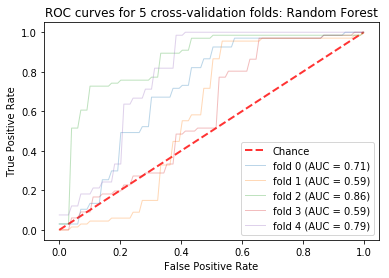

In [13]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Random Forest')

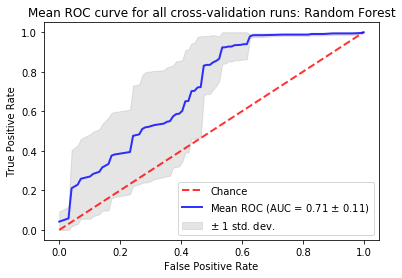

In [14]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF, aucs_RF, 'Random Forest')

In [15]:
### Train a Logistic Regression Classifier

In [16]:
# Create a Logistic Regression classifier object with default parameters
LR_classifier = LogisticRegression(solver ='lbfgs',fit_intercept=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
exec(eval_clf('LR'))

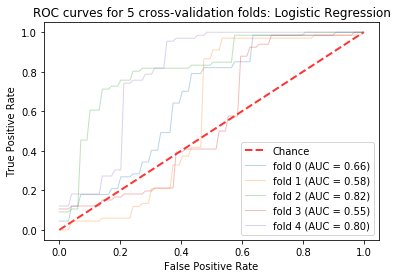

In [17]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_LR, aucs_LR, 'Logistic Regression')

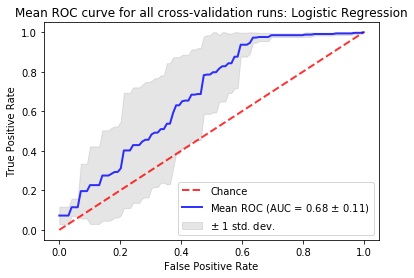

In [18]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_LR, aucs_LR, 'Logistic Regression')

### Compare All Trained Classifiers

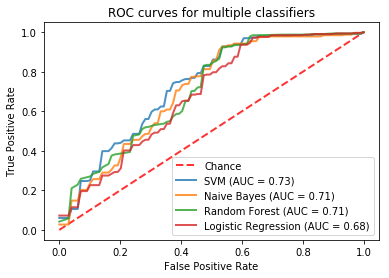

In [19]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0),np.mean(tprs_RF, axis=0),np.mean(tprs_LR, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB), np.mean(aucs_RF), np.mean(aucs_LR)]), 
                              np.array(['SVM', 'Naive Bayes', 'Random Forest','Logistic Regression' ]))

In [20]:
# Compare the statistics of the accuracies across all cross-validation folds
#accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB, 'Random Forest' : accuracies_RF, 'Logistic Regression' : accuracies_LR})
def eval_dataframe(clf_str):
    base_str = """accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB, 'Random Forest' : accuracies_RF, 'Logistic Regression' : accuracies_LR})"""
    return base_str.replace('accuracies',clf_str)

exec(eval_dataframe("accuracies"))

In [21]:
accuracies_df.describe()

,SVM,Naive Bayes,Random Forest,Logistic Regression
count,5.000000,5.000000,5.000000,5.000000
mean,0.808403,0.791670,0.804302,0.808403
std,0.029567,0.053465,0.029699,0.029567
min,0.778947,0.715789,0.773196,0.778947
25%,0.783505,0.762887,0.789474,0.783505
50%,0.812500,0.804124,0.802083,0.812500
75%,0.814433,0.822917,0.804124,0.814433
max,0.852632,0.852632,0.852632,0.852632


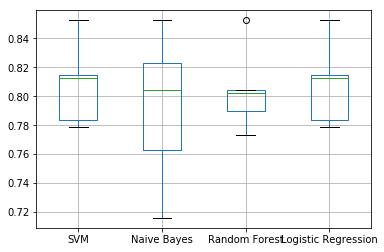

In [22]:
accuracies_df.boxplot()
plt.show()

In [23]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 'Naive Bayes' : f1_scores_NB, 'Random Forest' : f1_scores_RF, 'Logistic Regression' : f1_scores_LR})

In [24]:
f1_scores_df.describe()

,SVM,Naive Bayes,Random Forest,Logistic Regression
count,5.000000,5.000000,5.000000,5.000000
mean,0.876278,0.860583,0.872445,0.876278
std,0.017193,0.036598,0.018877,0.017193
min,0.860927,0.808511,0.851351,0.860927
25%,0.860927,0.839161,0.864865,0.860927
50%,0.878378,0.872483,0.870748,0.878378
75%,0.878378,0.882759,0.872483,0.878378
max,0.902778,0.900000,0.902778,0.902778


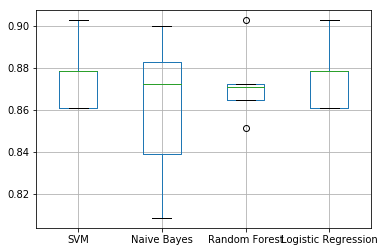

In [25]:
f1_scores_df.boxplot()
plt.show()

#### Conclusion

From above we can see that SVM and Logistic regression have the best outcome in terms of F1 and Accuracies.     
Where the green line is the median/average in those plots.   
Based on this I have chosen SVM for these Task to look further.   



## C. FInal Model

Assuming SVM was chosen, now we can train a final (to be potentially deployed) SVM model with the whole dataset:

In [26]:
model = SVM_classifier.fit(predictors, target)

Use the model to predict the type of three new seeds:

In [27]:
new_seeds = np.array([[0.4,0.5,0.6,0.5,0.5,0.2,0.3,0.5,0.5,0.2,0.3], 
                      [0.0,1.0,0.0,1.0,0.5,0.5,0.2,0.5,0.5,0.2,0], 
                      [0.2,0.2,0.2,1.0,0.2,0.2,0.2,0.2,0.2,0.2,0]])
new_seeds.shape

(3, 11)

In [28]:
# Probabilistic prediction
np.round(model.predict_proba(new_seeds), 2)
# Note: 
#   - the first column are the probabilities for the three new seeds to belong to class 0
#   - the second column are the probabilities for the three new seeds to belong to class 1

array([[0.83, 0.17],
       [0.81, 0.19],
       [0.81, 0.19]])

In [29]:
# Exact prediction
model.predict(new_seeds)

array([0, 0, 0])

## Task 2 (CS5062)

Modify the code in both Lab 4 - Comparison of Classifiers.ipynb and Lab4_Functions.ipynb to boxplot precision and recall for the classifiers trained with loans_et4.csv.   
Plot precision-recall curves for each of the trained classifiers as well.   
These should be the mean curves over all cross-validation runs. Update your conclusions from Task 1 after evaluating precision and recall.  

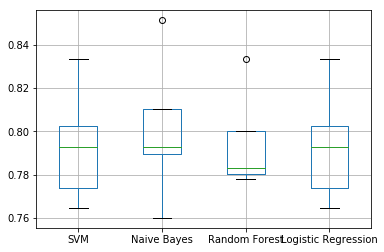

In [30]:
exec(eval_dataframe("precision"))
precision_df.boxplot()
plt.show()

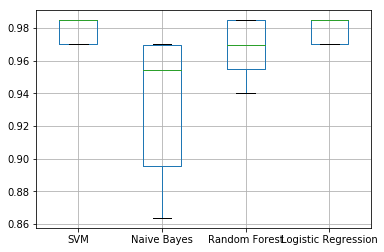

In [31]:
exec(eval_dataframe("recall"))
recall_df.boxplot()
plt.show()

In [32]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred,title = 'Title'):
    conf_mat = confusion_matrix(y_test, y_pred)    
    plt.figure(figsize=(10,5))
    ax = sn.heatmap(conf_mat,robust=True, square=False, cbar=True,cmap="Blues",annot=True,fmt='g')
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(title)
    plt.figure()
    plt.close()

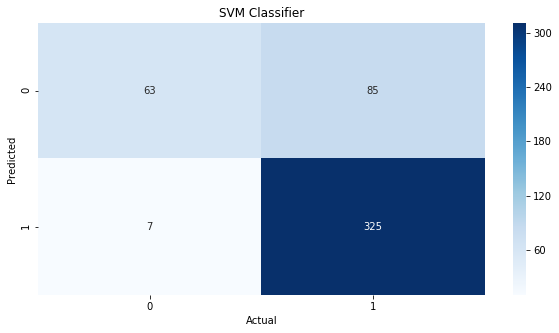

In [33]:
plot_confusion_matrix(target,SVM_classifier.predict(predictors),'SVM Classifier')

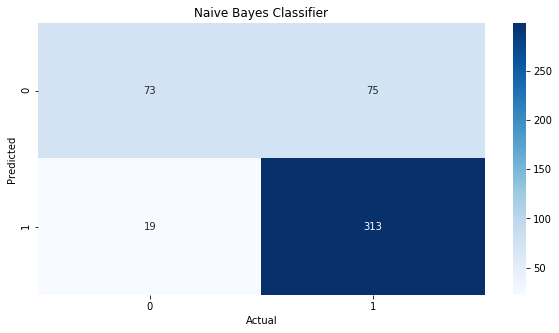

In [34]:
plot_confusion_matrix(target,NB_classifier.predict(predictors),'Naive Bayes Classifier')

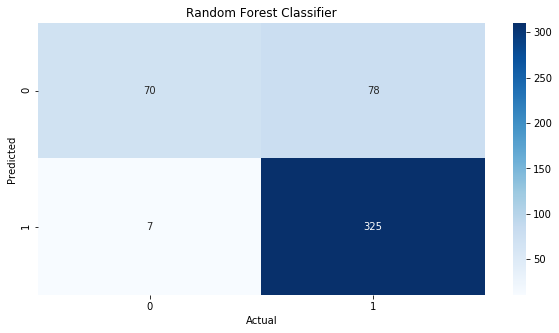

In [35]:
plot_confusion_matrix(target,RF_classifier.predict(predictors),'Random Forest Classifier')

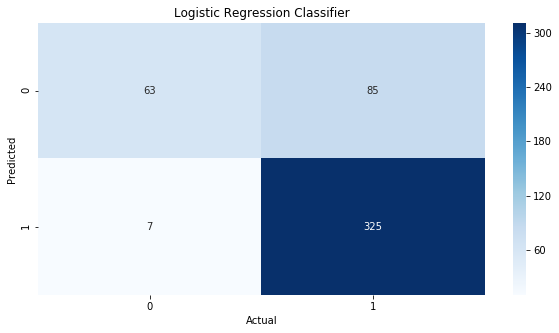

In [36]:
plot_confusion_matrix(target,LR_classifier.predict(predictors),'Logistic Regression Classifier')

Again the looks like SVM (and LR) as are the best when using the box plots.   
Using confusion matrix it looks like SVM is not doing well on the minority class and generating a lot of false positives.    
Random forest seems to balance the minority class better.


## Task 3 (CS5062)

Pick a winner among the classifiers you have trained with loans_et4.csv. Assume that it is important to minimise the false positives (i.e., Loan_Status predicted to be 1 wrongly).   
Look up the training parameters for this classifier on the scikit-learn website. For example, SVM has more than 10 parameters (see https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).    
Experiment with the parameters and see if you can improve the model in terms of accuracy, precision, recall and AUC.   
You do not have to build a better model but to show that you have explored some of its training parameters.   
Summarise your experience with exploring the parameters (max 150 words in a markdown cell).

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split( predictors, target, test_size=0.2, random_state=42)

#https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedKFold(n_splits=5, random_state=42)
grid = GridSearchCV(SVM_classifier, param_grid=param_grid, cv=cv ,n_jobs=-1,iid=False)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.80


In [50]:
 pd.DataFrame.from_dict(grid.cv_results_).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.020169,0.001547,0.002147,0.000173,0.01,1e-09,"{'C': 0.01, 'gamma': 1e-09}",0.692308,0.688312,0.688312,...,0.692734,0.004056,73,0.69281,0.693811,0.693811,0.691558,0.691558,0.69271,0.001009
1,0.024375,0.003562,0.002902,0.001432,0.01,1e-08,"{'C': 0.01, 'gamma': 1e-08}",0.692308,0.688312,0.688312,...,0.692734,0.004056,73,0.69281,0.693811,0.693811,0.691558,0.691558,0.69271,0.001009
2,0.020648,0.006717,0.001993,0.000949,0.01,1e-07,"{'C': 0.01, 'gamma': 1e-07}",0.692308,0.688312,0.688312,...,0.692734,0.004056,73,0.69281,0.693811,0.693811,0.691558,0.691558,0.69271,0.001009
3,0.024161,0.004546,0.001789,0.000240,0.01,1e-06,"{'C': 0.01, 'gamma': 1e-06}",0.692308,0.688312,0.688312,...,0.692734,0.004056,73,0.69281,0.693811,0.693811,0.691558,0.691558,0.69271,0.001009
4,0.020967,0.002123,0.001642,0.000128,0.01,1e-05,"{'C': 0.01, 'gamma': 1e-05}",0.692308,0.688312,0.688312,...,0.692734,0.004056,73,0.69281,0.693811,0.693811,0.691558,0.691558,0.69271,0.001009
5,0.018400,0.000539,0.001464,0.000258,0.01,0.0001,"{'C': 0.01, 'gamma': 0.0001}",0.692308,0.688312,0.688312,...,0.692734,0.004056,73,0.69281,0.693811,0.693811,0.691558,0.691558,0.69271,0.001009
6,0.020368,0.002753,0.001478,0.000090,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.692308,0.688312,0.688312,...,0.692734,0.004056,73,0.69281,0.693811,0.693811,0.691558,0.691558,0.69271,0.001009
7,0.018274,0.003951,0.001833,0.001383,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.692308,0.688312,0.688312,...,0.692734,0.004056,73,0.69281,0.693811,0.693811,0.691558,0.691558,0.69271,0.001009
8,0.021844,0.005092,0.001729,0.000414,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.692308,0.688312,0.688312,...,0.692734,0.004056,73,0.69281,0.693811,0.693811,0.691558,0.691558,0.69271,0.001009
9,0.020369,0.000750,0.001472,0.000132,0.01,1,"{'C': 0.01, 'gamma': 1.0}",0.692308,0.688312,0.688312,...,0.692734,0.004056,73,0.69281,0.693811,0.693811,0.691558,0.691558,0.69271,0.001009


C = 0.01 is consistently the best ranked outcome. Little variation based on gamma.

In [38]:
from sklearn.metrics import classification_report
print ("Train Recall After Grid Search")
print(classification_report(y_train, grid.predict(X_train)))
print ("Test Recall After Grid Search")
print(classification_report(y_test, grid.predict(X_test)))

Train Recall After Grid Search
              precision    recall  f1-score   support

           0       0.89      0.42      0.57       118
           1       0.79      0.98      0.87       266

   micro avg       0.80      0.80      0.80       384
   macro avg       0.84      0.70      0.72       384
weighted avg       0.82      0.80      0.78       384

Test Recall After Grid Search
              precision    recall  f1-score   support

           0       0.93      0.47      0.62        30
           1       0.80      0.98      0.88        66

   micro avg       0.82      0.82      0.82        96
   macro avg       0.87      0.73      0.75        96
weighted avg       0.84      0.82      0.80        96



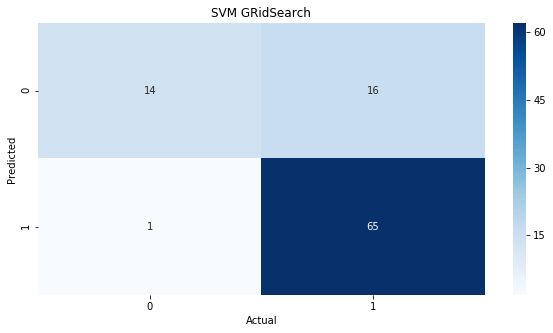

In [39]:
plot_confusion_matrix(y_test, grid.predict(X_test),'SVM GRidSearch')

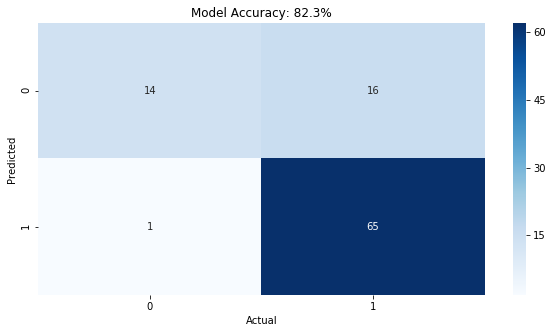

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'bootstrap': [False, True],
         'n_estimators': [80,90, 100, 110, 130,200],
         'max_features': [0.6, 0.65, 0.7, 0.73, 0.75, 0.78, 0.8],
         'min_samples_leaf': [10, 12, 14],
         'min_samples_split': [3, 5, 7]
        },
    ]

X_train, X_test, y_train, y_test = train_test_split( predictors, target, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5,scoring='neg_mean_squared_error', refit=True,n_jobs=-1,iid=False)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
plot_confusion_matrix(y_test, y_pred,'Model Accuracy: {:.1%}'.format(score))

In [53]:
pd.DataFrame.from_dict(grid_search.cv_results_).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.133134,0.042695,0.015245,0.008585,False,0.6,10,3,80,"{'bootstrap': False, 'max_features': 0.6, 'min...",...,-0.205688,0.022106,516,-0.166667,-0.175896,-0.159609,-0.178571,-0.175325,-0.171214,0.007047
1,0.129529,0.028957,0.009440,0.000375,False,0.6,10,3,90,"{'bootstrap': False, 'max_features': 0.6, 'min...",...,-0.205688,0.022106,516,-0.166667,-0.172638,-0.162866,-0.175325,-0.178571,-0.171214,0.005717
2,0.142580,0.019311,0.010362,0.000235,False,0.6,10,3,100,"{'bootstrap': False, 'max_features': 0.6, 'min...",...,-0.203124,0.021263,441,-0.156863,-0.175896,-0.159609,-0.175325,-0.175325,-0.168603,0.008512
3,0.147795,0.011388,0.011982,0.001211,False,0.6,10,3,110,"{'bootstrap': False, 'max_features': 0.6, 'min...",...,-0.205756,0.017635,564,-0.163399,-0.175896,-0.162866,-0.168831,-0.178571,-0.169913,0.006388
4,0.184910,0.003700,0.013739,0.000983,False,0.6,10,3,130,"{'bootstrap': False, 'max_features': 0.6, 'min...",...,-0.200527,0.021327,401,-0.153595,-0.175896,-0.156352,-0.178571,-0.175325,-0.167948,0.010686
5,0.275949,0.012136,0.021544,0.002690,False,0.6,10,3,200,"{'bootstrap': False, 'max_features': 0.6, 'min...",...,-0.203158,0.018094,495,-0.160131,-0.172638,-0.156352,-0.181818,-0.178571,-0.169902,0.010037
6,0.104319,0.006966,0.008398,0.000160,False,0.6,10,5,80,"{'bootstrap': False, 'max_features': 0.6, 'min...",...,-0.197895,0.025252,377,-0.160131,-0.175896,-0.162866,-0.175325,-0.168831,-0.168610,0.006373
7,0.115093,0.005197,0.009075,0.000193,False,0.6,10,5,90,"{'bootstrap': False, 'max_features': 0.6, 'min...",...,-0.205756,0.017635,564,-0.163399,-0.182410,-0.162866,-0.181818,-0.175325,-0.173164,0.008561
8,0.127967,0.006241,0.010179,0.000253,False,0.6,10,5,100,"{'bootstrap': False, 'max_features': 0.6, 'min...",...,-0.203158,0.018094,495,-0.160131,-0.175896,-0.162866,-0.175325,-0.185065,-0.171857,0.009177
9,0.141672,0.006251,0.011369,0.000336,False,0.6,10,5,110,"{'bootstrap': False, 'max_features': 0.6, 'min...",...,-0.200527,0.021327,401,-0.153595,-0.175896,-0.162866,-0.181818,-0.178571,-0.170549,0.010643


Number of leafs and estimator are inversly corrlatr 